<a href="https://colab.research.google.com/github/PhaniChandraSekhar/AIML_Practice/blob/main/AIML_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformer**

**Category:** Deep Learning (Supervised)

**Description:**
Attention-based architecture that processes sequential data without recurrence.

**Key Components:**
- Self-Attention Mechanism
- Multi-Head Attention
- Position Encodings
- Feed-Forward Networks

**Example Application:**

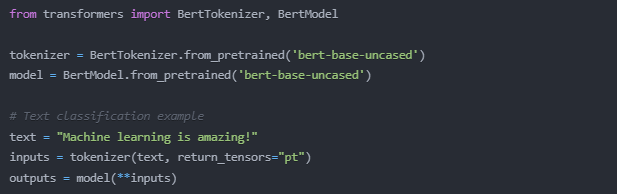


**Best Used For:**
- Natural language processing
- Text generation
- Translation
- Question answering systems


**Code Implementation Steps:**

The code uses the IMDb dataset from Hugging Face datasets for ease of use.

**Model Architecture:**

Multi-head self-attention
Positional encoding
Feed-forward networks
Layer normalization


**Data Processing:**

Text tokenization
Dataset creation
Data loading and batching
Sequence padding


**Training Pipeline:**

Custom training loop
Loss calculation
Optimization
Model evaluation


**Visualizations:**

Training history plots
Confusion matrix
Performance metrics
Loss curves



**Features:**

Complete Transformer implementation
IMDb sentiment analysis task
BERT tokenizer integration
Custom dataset class
Training visualization
Model evaluation
Example predictions

**Future steps to do:**

1. Add attention visualization?
2. Include more advanced preprocessing?
3. Add model interpretation techniques?
4. Implement different attention mechanisms?
5. Add more detailed architecture explanations?



In [ ]:
# Install required libraries
!pip install transformers tensorflow pandas numpy matplotlib seaborn scikit-learn torch datasets evaluate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class TransformerModel(nn.Module):
    def __init__(self, num_classes, d_model=512, nhead=8,
                 num_encoder_layers=6, dim_feedforward=2048, dropout=0.1):
        """Initialize Transformer model"""
        super(TransformerModel, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Transformer Encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead,
                                                  dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers,
                                                       num_encoder_layers)

        # Output layer
        self.fc = nn.Linear(d_model, num_classes)

        self.d_model = d_model
        self.init_weights()

    def init_weights(self):
        """Initialize weights"""
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        """Forward pass"""
        src = self.embedding(src) * np.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.fc(output.mean(dim=1))
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """Initialize positional encoding"""
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                           (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """Forward pass"""
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        """Initialize dataset"""
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
class TransformerTrainer:
    def __init__(self, model, optimizer, criterion, device):
        """Initialize trainer"""
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            # Forward pass
            outputs = self.model(input_ids)
            loss = self.criterion(outputs, labels)

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

        return total_loss / len(train_loader)

    def evaluate(self, val_loader):
        """Evaluate model"""
        self.model.eval()
        total_loss = 0
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, preds = torch.max(outputs, dim=1)
                predictions.extend(preds.cpu().tolist())
                true_labels.extend(labels.cpu().tolist())

        return (total_loss / len(val_loader),
                predictions,
                true_labels)

In [ ]:
def plot_training_history(history):
    """Plot training history"""
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(true_labels, predictions, classes):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [ ]:
def main():
    # Load IMDb dataset
    from datasets import load_dataset
    dataset = load_dataset("imdb")

    # Prepare data
    train_texts = dataset["train"]["text"]
    train_labels = dataset["train"]["label"]
    test_texts = dataset["test"]["text"]
    test_labels = dataset["test"]["label"]

    # Initialize tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

    # Create datasets
    train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
    test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = TransformerModel(num_classes=2).to(device)

    # Training settings
    optimizer = torch.optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    trainer = TransformerTrainer(model, optimizer, criterion, device)

    # Training loop
    num_epochs = 5
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Train
        train_loss = trainer.train_epoch(train_loader)

        # Evaluate
        val_loss, predictions, true_labels = trainer.evaluate(test_loader)

        # Calculate accuracy
        accuracy = sum(p == t for p, t in zip(predictions, true_labels)) / len(true_labels)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f}")

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(accuracy)
        history['val_acc'].append(accuracy)

    # Plot results
    plot_training_history(history)
    plot_confusion_matrix(true_labels, predictions, ['Negative', 'Positive'])

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions,
                              target_names=['Negative', 'Positive']))

    # Example prediction
    text = "This movie was absolutely fantastic! I loved every minute of it."
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    with torch.no_grad():
        outputs = model(input_ids)
        _, prediction = torch.max(outputs, dim=1)

    print(f"\nExample Prediction:")
    print(f"Text: {text}")
    print(f"Sentiment: {'Positive' if prediction.item() == 1 else 'Negative'}")

if __name__ == "__main__":
    main()